# SF HF WnB Quant Overlay (2025-05-18)
- Use a single Picture to demonstrate quantization effects
  [This notebook: Segformer_inference_notebook.ipynb](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb)
- [Notebooks](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/SegFormer)
- [Usage tips](https://huggingface.co/docs/transformers/en/model_doc/segformer#usage-tips)

In [1]:
use_uv = False

In [2]:
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
metric_used = "mean_iou"
save_path = "data"
save_path_models = "{save_path}/models"
dataset_name = "fixtures_ade20k"
ds_repo_id = f"hf-internal-testing/{dataset_name}"
wandb_tag_mode = "eval"
wandb_tag_runmode = "multiple-runs"
WANDB_PROJECT = f"segformer-{dataset_name}-{wandb_tag_mode}-{wandb_tag_runmode}"
WANDB_ENTITY = "pa-hf-sf-quant"

## Setup Python

In [3]:
requirements_txt = """
accelerate  # ==0.33.0
datasets  # ==3.2.0
evaluate  # ==0.4.3
matplotlib  # ==3.10.0
torch  # ==2.7.0
torchmetrics  # ==1.6.1
transformers  # ==4.47.1
wandb  # ==0.19.1

# quant methods
bitsandbytes  # ==0.45.0
# git+https://github.com/NetEase-FuXi/EETQ.git@v1.0.0
hqq  # ==0.2.6
# git+https://github.com/mobiusml/hqq.git@v0.2.5
# "optimum==1.24.0", # quanto, obsolete ?
optimum-quanto  # <=0.2.6
"""

In [4]:
pyproject_toml = """
[project]
version = "0.7.2"
name = "segformer-quantization-pipeline"
description = "An end-to-end quantization evaluation pipeline for SegFormer models on semantic segmentation tasks"
authors = [
    {name = "qte77", email = "qte@77.gh"}
]
readme = "README.md"
requires-python = "==3.11.*"
dependencies = [
    "accelerate==0.33.0",
    "datasets==3.2.0",
    "evaluate==0.4.3",
    "matplotlib==3.10.0",
    "torch==2.7.0",
    "torchmetrics==1.6.1",
    "transformers==4.47.1",
    "wandb==0.19.1",

    # quant methods
    "bitsandbytes==0.45.0",
    # "eetq",
    "hqq==0.2.6",
    # "optimum==1.24.0", # quanto, obsolete ?
    "optimum-quanto<=0.2.6",
]

# https://docs.astral.sh/uv/concepts/projects/dependencies/#optional-dependencies
# [project.optional-dependencies]

# Dependency groups
# https://docs.astral.sh/uv/concepts/projects/dependencies/#development-dependencies
# By default, uv includes the dev dependency group in the environment
# https://docs.astral.sh/uv/concepts/projects/dependencies/#default-groups
[dependency-groups]
dev = [
    "pydantic>=2.10.4",
    "pytest>=8.3.4",
    "ruff>=0.8.4",
    # "git-changelog>=2.5.2"
]
docs = [
    "griffe>=1.5.1",
    "mkdocs>=1.6.1",
    "mkdocs-awesome-pages-plugin>=2.9.3",
    "mkdocs-gen-files>=0.5.0",
    "mkdocs-literate-nav>=0.6.1",
    "mkdocs-material>=9.5.44",
    "mkdocs-section-index>=0.3.8",
    "mkdocstrings[python]>=0.27.0"
]

[tool.uv]
package = true
exclude-newer = "2025-05-15T00:00:00Z"

[tool.uv.sources]
eetq = { git = "https://github.com/NetEase-FuXi/EETQ.git", rev = "v1.0.0" }
# hqq = { git = "https://github.com/mobiusml/hqq.git", rev = "v0.2.5" }
"""

In [5]:
"""/usr/local/lib/python3.11/dist-packages/pyproject.toml"""
if use_uv:
    reqs_to_use = pyproject_toml
    file = "pyproject.toml"
else:
    reqs_to_use = requirements_txt
    file = "requirements.txt"
    
with open(file, 'w') as f:
    f.write(reqs_to_use)

In [6]:
%%bash -s "$use_uv"
python --version
if [ "$1" = "True" ]; then
    # UV_PROJECT_ENVIRONMENT="/usr/lib/python3/dist-packages"
    uv_install_into="/usr/local/lib/python3.11/dist-packages"
    uv_ver_req="0.7.3"
    uv_ver_installed=$(uv --version | awk '{print $2}')
    if [[ ! "$uv_ver_installed" == "$uv_ver_req" ]]
        then pip install uv==$uv_ver_req  -q
    fi
    echo "'$(uv --version )' installed"
    uv sync --directory $uv_install_into
    # uv export --format requirements.txt -o requirements.txt --no-build-isolation --no-editable -q
else
    pip install -r requirements.txt -qqq
fi

Python 3.11.11
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.8 MB/s eta 0:00:00


DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/hqq_aten-0.0.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [7]:
# add uv .venv to python path
if use_uv:
    import sys
    # uv_python_path = "/kaggle/working/.venv/lib/python3.11/site-packages"
    # sys.path.insert(0, uv_python_path)
    print(sys.path)

In [8]:
from math import ceil

In [114]:
from torch import device, float32, no_grad
from torch.cuda import is_available, device_count
import torch.nn.functional as F
from huggingface_hub import hf_hub_download
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import wandb

In [10]:
from accelerate import Accelerator
from evaluate import load
from transformers import (
    PreTrainedModel,
    BaseImageProcessor,
    SegformerForSemanticSegmentation,
    SegformerImageProcessor,
    QuantoConfig,
    GPTQConfig,
    BitsAndBytesConfig,
    HqqConfig,
    EetqConfig,
)
from hqq.core.quantize import BaseQuantizeConfig as HqqBaseCfg
from hqq.models.hf.base import AutoHQQHFModel

2025-05-18 20:31:40.853307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747600301.343157      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747600301.468830      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [82]:
import bitsandbytes
import optimum
try:
  _ = HqqConfig()
  hqq_conf_available = True
except:
  from hqq.core.quantize import BaseQuantizeConfig
  from hqq.models.hf.base import AutoHQQHFModel
  hqq_conf_available = False

In [12]:
!uv -q pip install kaggle==1.7.4.5
from kaggle_secrets import UserSecretsClient

In [115]:
device_count = device_count()
print(f"{device_count=}")
device_used = device("cuda" if is_available() else "cpu")
# to avoid ValueError: `.to` is not supported for HQQ-quantized models.
device_hqq = None if hqq_conf_available else device_used

device_count=2


## Functions

In [96]:
def save_model_locally(model, save_directory) -> str:
    save_directory = f"{save_directory}/{model.name_or_path}"
    model.save_pretrained(save_directory)
    return save_directory

def load_model_locally(model_path, quant_config, device = None) -> SegformerForSemanticSegmentation:
    model = SegformerForSemanticSegmentation.from_pretrained(
            model_path,
            quantization_config=quant_config,
            # torch_dtype=compute_dtype,
            # device_map="auto"
        )
    if device is None:
        return model
    else:
        return model.to(device)
    
def get_base_model(device):
    return SegformerForSemanticSegmentation.from_pretrained(
        model_name
    ).to(device)

def get_halfed_model(model):
    return deepcopy(model).half()

In [ ]:
#@title `Palette`
#TODO export to utils
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

### Quant methods

In [363]:
def get_bnb_cfg(num_bits_4: bool) -> BitsAndBytesConfig:
    """Get BitsAndBytes Quantization configuration"""
    if num_bits_4:
        load_bit_num = {
            "load_in_4bit": True,
        }
    else:
        load_bit_num = {
            "load_in_8bit": True
        }        
    return BitsAndBytesConfig(
        **load_bit_num
    )

def get_quanto_cfg(bit_config: str) -> QuantoConfig:
    config_quanto = {}
    bits_quanto_avail = ['float8', 'int8', 'int4', 'int2']
    if bit_config not in bits_quanto_avail:
        raise ValueError(
            f"{bit_config} not in {bits_quanto_avail=}"
        )
    return QuantoConfig(
        weights=bit_config,
        # activations=bit_config  # not suported with hf
    )
    
def get_hqq_cfg(bit_config: str, device) -> QuantoConfig:
    bits_hqq_avail = [8, 4, 3, 2, 1]
    if bit_config not in bits_hqq_avail:
        raise ValueError(
            f"{bit_config} not in {bits_hqq_avail=}"
        )
    config_hqq = {}
    config_hqq_default = {
        'group_size': 64, 'quant_zero': False,
        'quant_scale': False, 'axis': 0
    }
    if hqq_conf_available:
        config_hqq_default['nbits'] = bit_config
        return HqqConfig(
            **config_hqq_default
        )
    else:
        config_hqq_custom = {}
        config_hqq_custom_device = {}
        cfg_cust, cfg_cust_dev = {}, {}
        config_hqq = BaseQuantizeConfig(
            **config_hqq_default
        )
        for layer in model_orig.named_parameters():
            cfg_cust[layer[0]] = config_hqq
            cfg_cust_dev[layer[0]] = device
    
        config_hqq_custom[nbits] = cfg_cust
        config_hqq_custom_device[nbits] = cfg_cust_dev
        return config_hqq_custom, config_hqq_custom_device

## Models

In [364]:
%%time
models = { "base": get_base_model(device_used) }
base_model_path = save_model_locally(models["base"], save_path_models)    
models.update({ "half": get_halfed_model(models["base"]) })
for bit_config in [8, 4]:
    models.update({
    f"bnb-{bit_config}": load_model_locally(
        base_model_path,
        get_bnb_cfg(bit_config),
        device_used
    )
})
for bit_config in ['float8', 'int8', 'int4', 'int2']:
    models.update({
    f"quanto-{bit_config}": load_model_locally(
        base_model_path,
        get_quanto_cfg(bit_config),
        device_used
    )
})
for bit_config in [8, 4, 3, 2, 1]:
    models.update({
    f"hqq-{bit_config}": load_model_locally(
        base_model_path,
        get_hqq_cfg(bit_config, device_hqq),
        device_hqq
    )
})

CPU times: user 7.54 s, sys: 115 ms, total: 7.65 s
Wall time: 4.78 s


In [365]:
models_attribs = {}
for name, model in models.items():
    models_attribs[name] = {
        "memory": model.get_memory_footprint(),
        "device": next(model.parameters()).device
    }
    print(f"{name}: {models_attribs[name]}")

base: {'memory': 15012832, 'device': device(type='cuda', index=0)}
half: {'memory': 7506420, 'device': device(type='cuda', index=0)}
bnb-8: {'memory': 3844596, 'device': device(type='cuda', index=0)}
bnb-4: {'memory': 3844596, 'device': device(type='cuda', index=0)}
quanto-float8: {'memory': 15013248, 'device': device(type='cuda', index=0)}
quanto-int8: {'memory': 15013248, 'device': device(type='cuda', index=0)}
quanto-int4: {'memory': 15013248, 'device': device(type='cuda', index=0)}
quanto-int2: {'memory': 15013248, 'device': device(type='cuda', index=0)}
hqq-8: {'memory': 7689184, 'device': device(type='cpu')}
hqq-4: {'memory': 6468576, 'device': device(type='cpu')}
hqq-3: {'memory': 6316000, 'device': device(type='cpu')}
hqq-2: {'memory': 5858272, 'device': device(type='cpu')}
hqq-1: {'memory': 5553120, 'device': device(type='cpu')}


## Dataset

(683, 512)


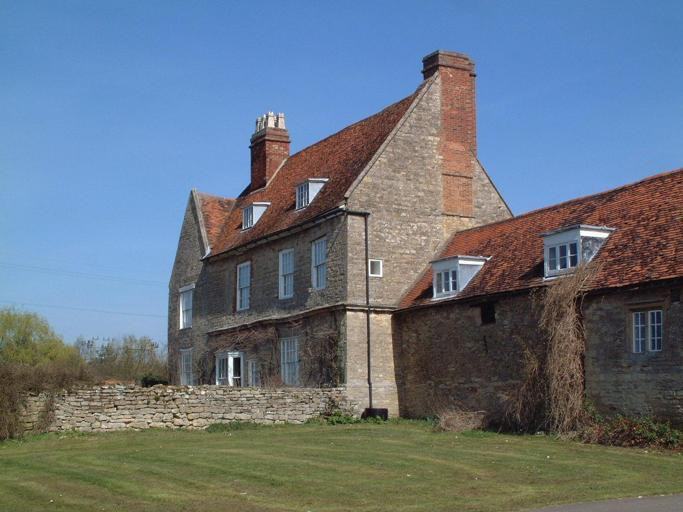

In [107]:
# load image + ground truth map
image_path = hf_hub_download(
    repo_id=ds_repo_id,
    filename="ADE_val_00000001.jpg",
    repo_type="dataset"
)

image = Image.open(image_path)
segmentation_map_path = hf_hub_download(
    repo_id=ds_repo_id,
    filename="ADE_val_00000001.png",
    repo_type="dataset"
)
segmentation_map = Image.open(segmentation_map_path)
print(image.size)
image

## Image processor

In [108]:
processor = SegformerImageProcessor(
    do_resize=False,
    # size={"height": 640, "width": 640}
)

In [318]:
processed_image = processor(
    image, return_tensors="pt",
    segmentation_maps=segmentation_map
)
pixel_values = processed_image.pixel_values
labels = processed_image.labels
print(pixel_values.shape)
print(labels.shape)

torch.Size([1, 3, 512, 683])
torch.Size([1, 512, 683])


## Metric

In [331]:
models_metrics = {}
metric = load("mean_iou")

## Forward pass

In [349]:
def get_metrics(logits, labels) -> dict[str, float]:
    # logits   # Shape: [batch, num_classes, height, width]
    preds = logits.argmax(dim=1)    # Shape: [batch, pred_height, pred_width]
    preds = F.interpolate(
        preds.unsqueeze(1).float(),  # Add channel dim: [batch, 1, pred_height, pred_width]
        size=labels.shape[-2:],      # Target size: [label_height, label_width]
        mode="nearest"               # Preserve class indices (no interpolation)
    ).squeeze(1).long()              # Remove channel dim: [batch, label_height, label_width]
    results = metric.compute(
        predictions=[preds.squeeze(0).cpu().numpy()],
        references=[labels.squeeze(0).cpu().numpy()],
        num_labels=150,
        ignore_index=False
    )
    return {
        "mean_iou": results["mean_iou"],
        "mean_accuracy": results["mean_accuracy"]
    }

In [350]:
%%time
outputs, logits = {}, {}
for model in models.keys():    
    if model == "half" or model.startswith("bnb"):
        pv = deepcopy(pixel_values).half()
    else:
        pv = pixel_values
    if not model.startswith("hqq") or not hqq_conf_available:
        pv = pv.to(device_used)
    try:
        with no_grad():
            outputs[model] = models[model](pv)
        logits[model] = outputs[model].logits
        print(f"{model}: {logits[model].shape}")
    except Exception as e:
        print(f"{model}: {e}")
        continue
    models_metrics[model] = get_metrics(logits[model], labels)

base: torch.Size([1, 150, 128, 171])
half: torch.Size([1, 150, 128, 171])
bnb-8: torch.Size([1, 150, 128, 171])
bnb-4: torch.Size([1, 150, 128, 171])
quanto-float8: torch.Size([1, 150, 128, 171])
quanto-int8: torch.Size([1, 150, 128, 171])
quanto-int4: /usr/local/lib/python3.11/dist-packages/optimum/quanto/library/extensions/cuda/build/quanto_cuda.so: cannot open shared object file: No such file or directory
quanto-int2: /usr/local/lib/python3.11/dist-packages/optimum/quanto/library/extensions/cuda/build/quanto_cuda.so: cannot open shared object file: No such file or directory
hqq-8: torch.Size([1, 150, 128, 171])
hqq-4: torch.Size([1, 150, 128, 171])
hqq-3: torch.Size([1, 150, 128, 171])
hqq-2: torch.Size([1, 150, 128, 171])
hqq-1: torch.Size([1, 150, 128, 171])
CPU times: user 4.98 s, sys: 966 ms, total: 5.95 s
Wall time: 3.2 s


## Visualization

In [210]:
palette = np.array(ade_palette())
palette.shape

(150, 3)

In [353]:
predicted_segmentation_maps = {}
for model in outputs.keys():
    predicted_segmentation_maps[model] = processor.post_process_semantic_segmentation(
            outputs[model], target_sizes=[image.size[::-1]]
        )[0].cpu().numpy()
    print(f"{model}: {predicted_segmentation_maps[model].shape=}")

base: predicted_segmentation_maps[model].shape=(512, 683)
half: predicted_segmentation_maps[model].shape=(512, 683)
bnb-8: predicted_segmentation_maps[model].shape=(512, 683)
bnb-4: predicted_segmentation_maps[model].shape=(512, 683)
quanto-float8: predicted_segmentation_maps[model].shape=(512, 683)
quanto-int8: predicted_segmentation_maps[model].shape=(512, 683)
hqq-8: predicted_segmentation_maps[model].shape=(512, 683)
hqq-4: predicted_segmentation_maps[model].shape=(512, 683)
hqq-3: predicted_segmentation_maps[model].shape=(512, 683)
hqq-2: predicted_segmentation_maps[model].shape=(512, 683)
hqq-1: predicted_segmentation_maps[model].shape=(512, 683)


In [367]:
num_plots = len(predicted_segmentation_maps.keys()) + 1
fig_cols = 2
fig_rows = ceil(num_plots / fig_cols)
mosaic_layout = []
i = 0
for r in range(fig_rows):
    row = []
    for c in range(fig_cols):
        row.append(i)
        i += 1
    mosaic_layout.append(row)
mosaic_layout

[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]]

In [357]:
models_attribs

{'base': {'memory': 15012832, 'device': device(type='cuda', index=0)},
 'half': {'memory': 7506420, 'device': device(type='cuda', index=0)},
 'bnb-8': {'memory': 3844596, 'device': device(type='cuda', index=0)},
 'bnb-4': {'memory': 3844596, 'device': device(type='cuda', index=0)},
 'quanto-float8': {'memory': 15013248, 'device': device(type='cuda', index=0)},
 'quanto-int8': {'memory': 15013248, 'device': device(type='cuda', index=0)},
 'quanto-int4': {'memory': 15013248, 'device': device(type='cuda', index=0)},
 'quanto-int2': {'memory': 15013248, 'device': device(type='cuda', index=0)},
 'hqq-8': {'memory': 7689184, 'device': device(type='cpu')},
 'hqq-4': {'memory': 6468576, 'device': device(type='cpu')},
 'hqq-3': {'memory': 6316000, 'device': device(type='cpu')},
 'hqq-2': {'memory': 5858272, 'device': device(type='cpu')},
 'hqq-1': {'memory': 5553120, 'device': device(type='cpu')}}

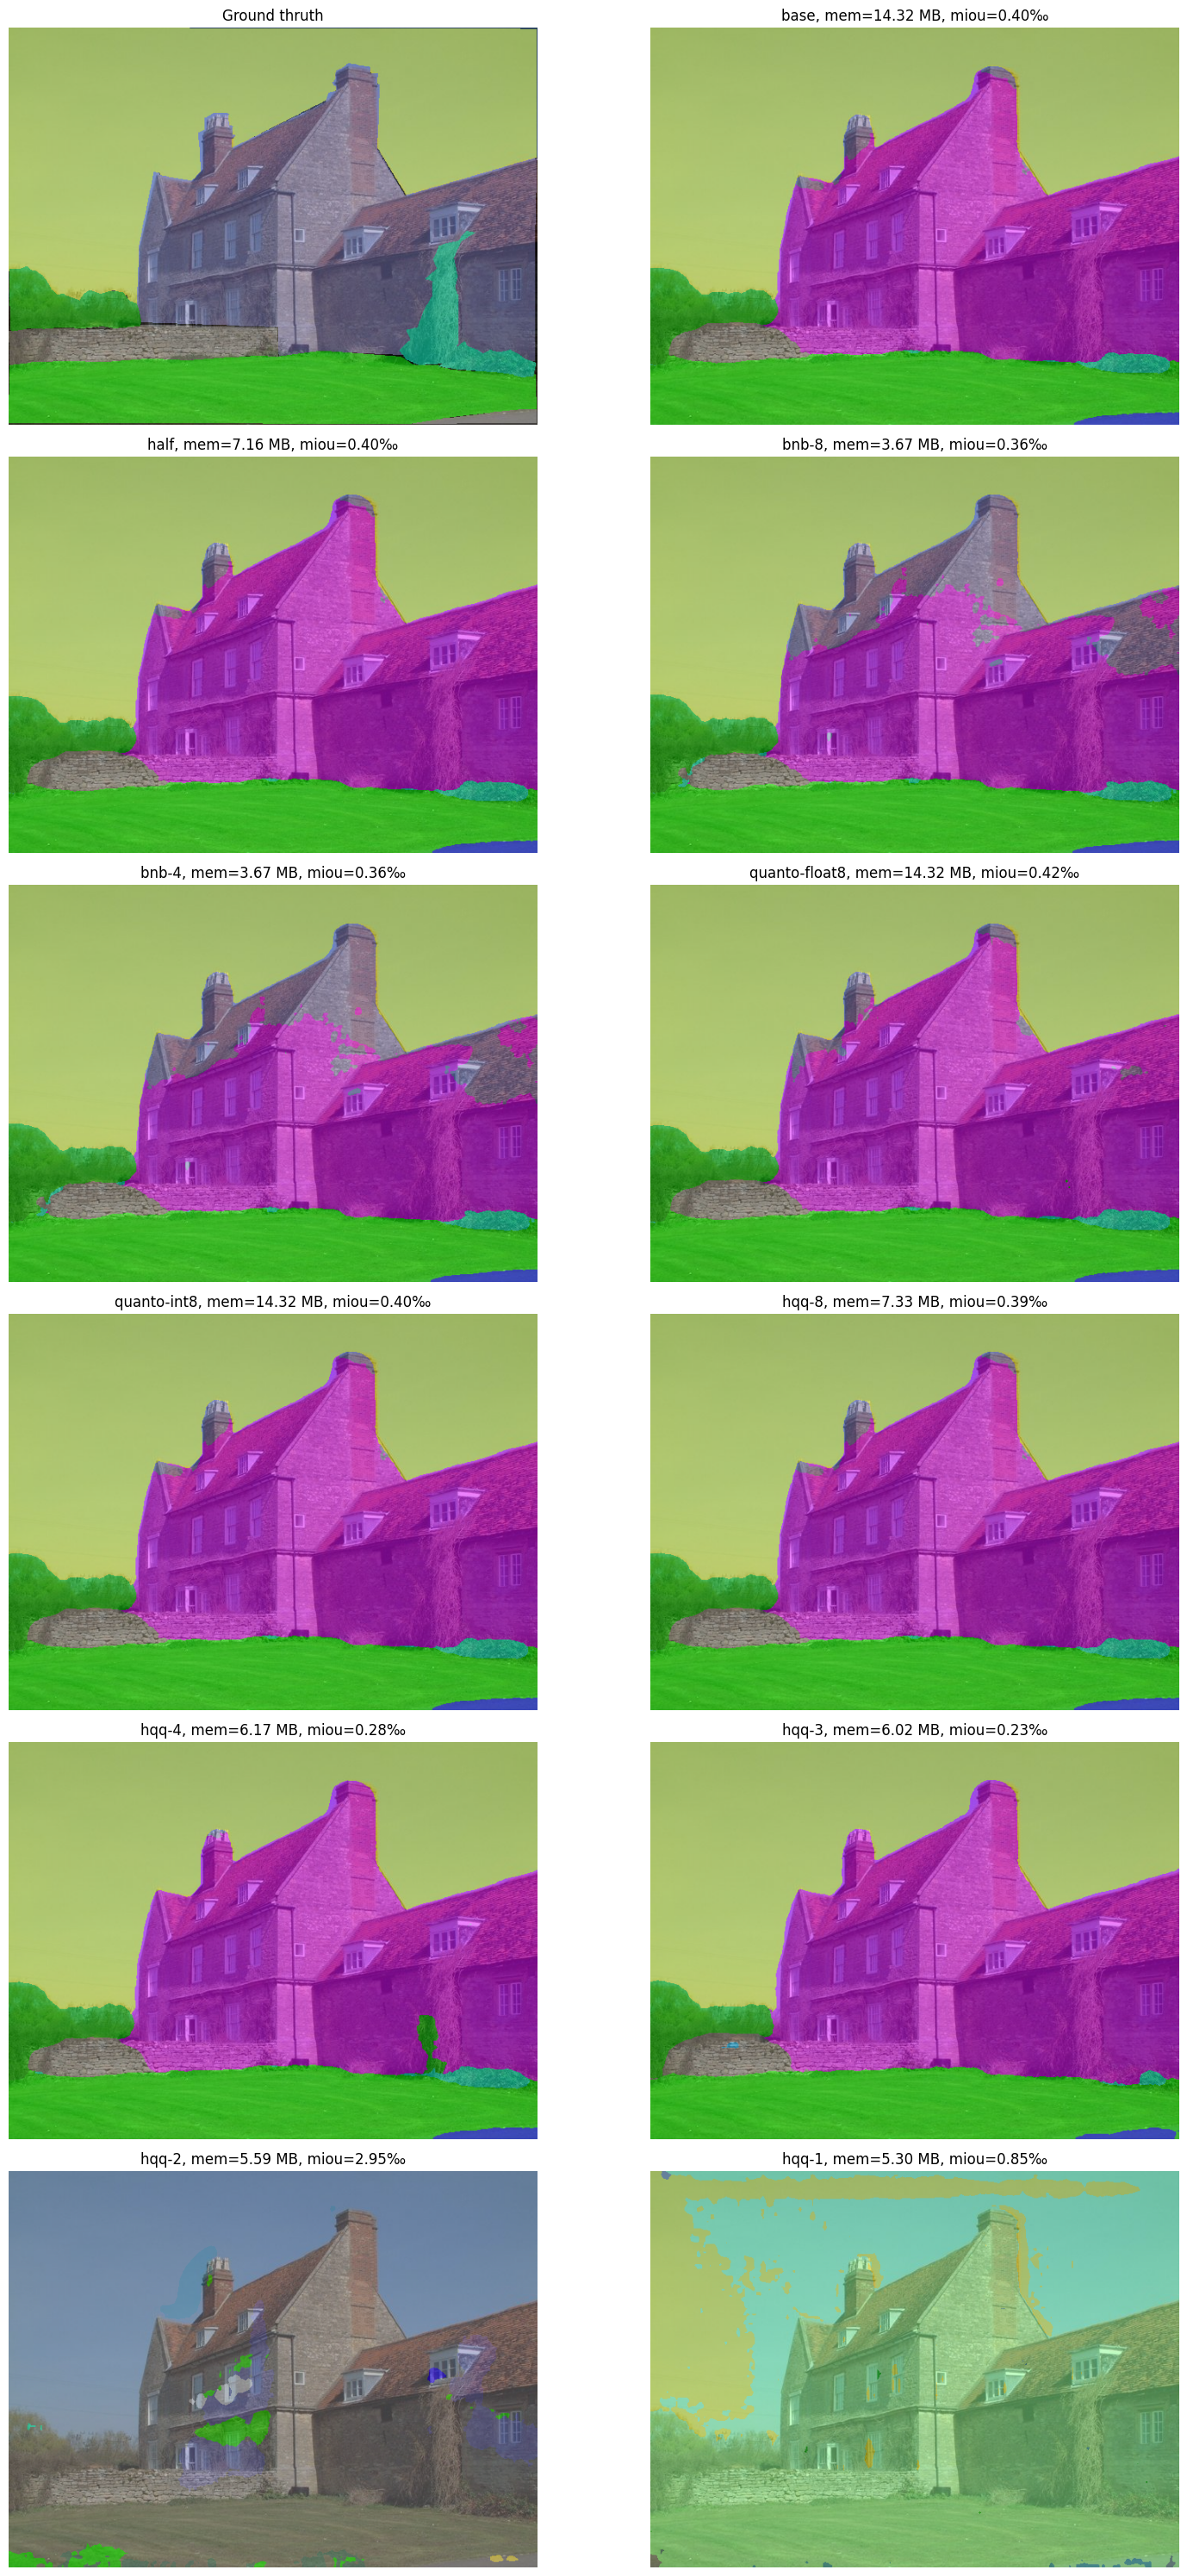

CPU times: user 3.46 s, sys: 43.2 ms, total: 3.5 s
Wall time: 3.24 s


In [376]:
%%time
fig, axes = plt.subplot_mosaic(mosaic_layout, figsize=(45, 30))  # , constrained_layout=True

ground_truth_seg = np.array(segmentation_map) # 2D ground truth segmentation map
ground_truth_color_seg = np.zeros((ground_truth_seg.shape[0], ground_truth_seg.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    ground_truth_color_seg[ground_truth_seg - 1 == label, :] = color
# Convert to BGR
ground_truth_color_seg = ground_truth_color_seg[..., ::-1]
img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title("Ground thruth")

for i, model in enumerate(predicted_segmentation_maps.keys()):
    color_seg = np.zeros((
        predicted_segmentation_maps[model].shape[0],
        predicted_segmentation_maps[model].shape[1], 3
    ), dtype=np.uint8) # height, width, 3
    for label, color in enumerate(palette):
        color_seg[predicted_segmentation_maps[model] == label, :] = color
    # Convert to BGR
    color_seg = color_seg[..., ::-1]
    # overlay
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)
        
    # arrange plot
    axes[i+1].imshow(img)
    axes[i+1].axis('off')
    mem = models_attribs[model]["memory"] / (1024 * 1024)
    miou = models_metrics[model]["mean_iou"] * 1000
    axes[i+1].set_title(f"{model}, {mem=:.2f} MB, {miou=:.2f} ‰")
        
for i, ax in axes.items():
    if i > num_plots - 1: fig.delaxes(ax)

fig.tight_layout()
plt.subplots_adjust(wspace=-.8)  # fraction if figsize
plt.show()

del fig, axes, color_seg, img
